<h1>Análisis regional del impacto del COVID-19 en España<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducción" data-toc-modified-id="Introducción-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introducción</a></span></li><li><span><a href="#Procesado-de-datos" data-toc-modified-id="Procesado-de-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Procesado de datos</a></span></li><li><span><a href="#Visualizaciones" data-toc-modified-id="Visualizaciones-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualizaciones</a></span><ul class="toc-item"><li><span><a href="#Evolución-de-la-tasa-de-mortalidad" data-toc-modified-id="Evolución-de-la-tasa-de-mortalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Evolución de la tasa de mortalidad</a></span></li><li><span><a href="#Evolución-de-la-tasa-de-letalidad" data-toc-modified-id="Evolución-de-la-tasa-de-letalidad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Evolución de la tasa de letalidad</a></span></li><li><span><a href="#Evolución-tasa-de-recuperación" data-toc-modified-id="Evolución-tasa-de-recuperación-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Evolución tasa de recuperación</a></span></li><li><span><a href="#Mortalidad-vs.-Letalidad" data-toc-modified-id="Mortalidad-vs.-Letalidad-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Mortalidad vs. Letalidad</a></span></li><li><span><a href="#Mapa-de-mortalidad" data-toc-modified-id="Mapa-de-mortalidad-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Mapa de mortalidad</a></span></li><li><span><a href="#Mapa-de-letalidad" data-toc-modified-id="Mapa-de-letalidad-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Mapa de letalidad</a></span></li></ul></li></ul></div>

# Introducción

--------
Este notebook contiene un análisis regional del impacto del COVID-19 en España. 

Los datos de casos, hospitalizados, hospitalizados en la UCI, fallecidos y recuperados han sido extraídos de la web de [Instituto de Salud Carlos III](https://covid19.isciii.es). Por otro lado, el censo de España ha sido obtenido a partir de los últimos datos disponibles del [Insituto Nacional de Estadística](https://www.ine.es/jaxiT3/Datos.htm?t=2915)


La sección Procesado de datos fue iniciada por [@manu-jimenez](https://github.com/manu-jimenez) en su [notebook](https://github.com/manu-jimenez/covid19-manu/blob/master/covid19-manu.ipynb).


--------

In [169]:
# Libraries and figure settings

import io
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import matplotlib
plt.style.use('fivethirtyeight')

ModuleNotFoundError: No module named 'geopandas'

# Procesado de datos

In [150]:
# Constants, variables and dictionaries

init_quarantine = np.datetime64('2020-03-15')
init_strict_quarantine = np.datetime64('2020-03-30')


names_ccaa = {'AN':'Andalucía',
                'AR':'Aragón',
                'AS':'Asturias',
                'CB':'Cantabria',
                'CE':'Ceuta',
                'CL':'Castilla y León',
                'CM':'Castilla-La Mancha', 
                'CN':'Canarias', 
                'CT':'Cataluña', 
                'EX':'Extremadura',
                'GA':'Galicia',
                'IB':'Baleares', 
                'MC':'Murcia', 
                'MD':'Madrid', 
                'ME':'Melilla',
                'NC':'Navarra',
                'PV':'País Vasco',
                'RI':'La Rioja', 
                'VC':'Comunidad Valenciana'
               }

In [156]:
# Get COVID-19 data 
req = requests.get("https://covid19.isciii.es/resources/serie_historica_acumulados.csv")
csv = req.content.decode('ISO-8859-1')

filename = 'serie_historica_acumulados.csv'
with open(filename, 'w') as f:
    f.write(csv)
    
# Load population file (Source: INE)
population = pd.read_csv('censo_espana_2019.csv',sep=';')
population.replace({'Region': names_ccaa}, inplace= True)

In [152]:
# Create dataframe. # If there is no data use: df0 = pd.read_csv('./download_data/serie_historica_acumulados.csv')
df = pd.read_csv(io.StringIO(csv), sep=',', skipfooter=1, parse_dates=[1], dayfirst=True, engine='python')

# Rename columns and replace CCAA codes
df.rename(columns={'CCAA Codigo ISO': 'Region', 'Casos ': 'Casos'}, inplace = True)
df.replace({'Region': names_ccaa}, inplace= True)

# Fill nan's
df[['Casos', 'Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados']] = df[['Casos', 'Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados']].fillna(0)

# Compute total
df = df.sort_values(by=['Region','Fecha']).reset_index(drop=True)
total_spain = df.groupby('Fecha').sum().reset_index()
total_spain['Region'] = ['España'] * len(total_spain)

# Concatenate both df and total_spain
df = pd.concat([total_spain, df])

# Add day
df['Dia'] = df.groupby('Region')['Fecha'].transform(lambda x: x - x.iloc[0]).dt.days 

# Only take data if deaths > 100
df = df[df['Casos']>1]

df.head()

,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados,Region,Dia
0,2020-02-20,2.0,0.0,0.0,0.0,0.0,España,0.0
1,2020-02-21,2.0,0.0,0.0,0.0,0.0,España,1.0
2,2020-02-22,2.0,0.0,0.0,0.0,0.0,España,2.0
3,2020-02-23,2.0,0.0,0.0,0.0,0.0,España,3.0
4,2020-02-24,3.0,0.0,0.0,0.0,0.0,España,4.0


In [155]:
population.head()

,Region,Population
0,España,47026208
1,Andalucía,8414240
2,Aragón,1319291
3,Asturias,1022800
4,Baleares,1149460


In [157]:
# Compute new metrics using population by region
df = df.merge(population, 'left', on='Region')

df['Casos_per_capita'] = df['Casos'] / df['Population'] * 100
df['Hospitalizados_por_casos'] = df['Hospitalizados'] / df['Casos'] * 100
df['UCI_por_hospitalizados'] = df['UCI'] / df['Hospitalizados'] * 100
df['Letalidad'] = df['Fallecidos'] / df['Casos'] * 100
df['Mortalidad'] = df['Fallecidos'] / df['Population'] * 100
df['Tasa_recuperados'] = df['Recuperados'] / df['Casos'] * 100

In [158]:
df.columns

Index(['Fecha', 'Casos', 'Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados',
       'Region', 'Dia', 'Population_x', 'Casos_per_capita',
       'Hospitalizados_por_casos', 'UCI_por_hospitalizados', 'Letalidad',
       'Mortalidad', 'Recuperacion', 'Population_y', 'Population',
       'Tasa_recuperados'],
      dtype='object')

# Visualizaciones

In [238]:
# Lists and constants
ccaa_list = list(df['Region'].drop_duplicates())
number_ccaa = len(ccaa_list)
ncols=3
nrows=round(len(ccaa_list)/ncols)

# generateRegionsPlot creates the main plots of this notebooks: grid plots to analize variables by region.
def generateRegionsPlot(variable, supTitle, yLabel, varColor):

    fig = plt.figure(figsize=(20,20))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)
    for element,i in zip(ccaa_list, range(1, len(ccaa_list)+1)):
        df_by_region = df[df['Region']==element][['Dia',variable]]
        ax = fig.add_subplot(nrows, ncols, i)
        if element!='España':
            ax.plot(range(len(df_by_region[variable])), df_by_region[variable], color = varColor, label = 'Región')
        ax.plot(range(len(df[df['Region']=='España'][variable])), df[df['Region']=='España'][variable], color='gray', label ='España')
        ax.set_title(element)
        ax.set(xlabel='Día', ylabel=yLabel)


    fig.suptitle(supTitle,y=1.1, fontsize=35)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels,bbox_to_anchor=(0.35, 1.04, 0.3,0), mode='expand',ncol=2, fontsize=20)
    fig.text(0.2, 1.06, r'El día 0 corresponde al primer día en el que hubo un primer caso confirmado en la región'
         ,alpha=0.6, fontsize=18)
    fig.tight_layout()
    return plt.show()


# scatterPlot generates a scatter plot to compare two variables 
def scatterPlot(varX,varY, xLabel, yLabel, titlePlot):
    fig = plt.figure(figsize=(20,15))
    for element,i in zip(ccaa_list, range(1, len(ccaa_list)+1)):
        if element!='España':
            df_by_region = df[df['Region']==element][[varX,varY]]
            x = df_by_region[varX].iloc[-1]
            y = df_by_region[varY].iloc[-1]
            plt.scatter(x, y, s=100*(x+y), alpha=0.4, edgecolors="grey", linewidth=2)
            plt.text(x, y, element, fontsize=12)
        
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(titlePlot, fontsize=35)
    plt.show()

## Evolución de la tasa de mortalidad

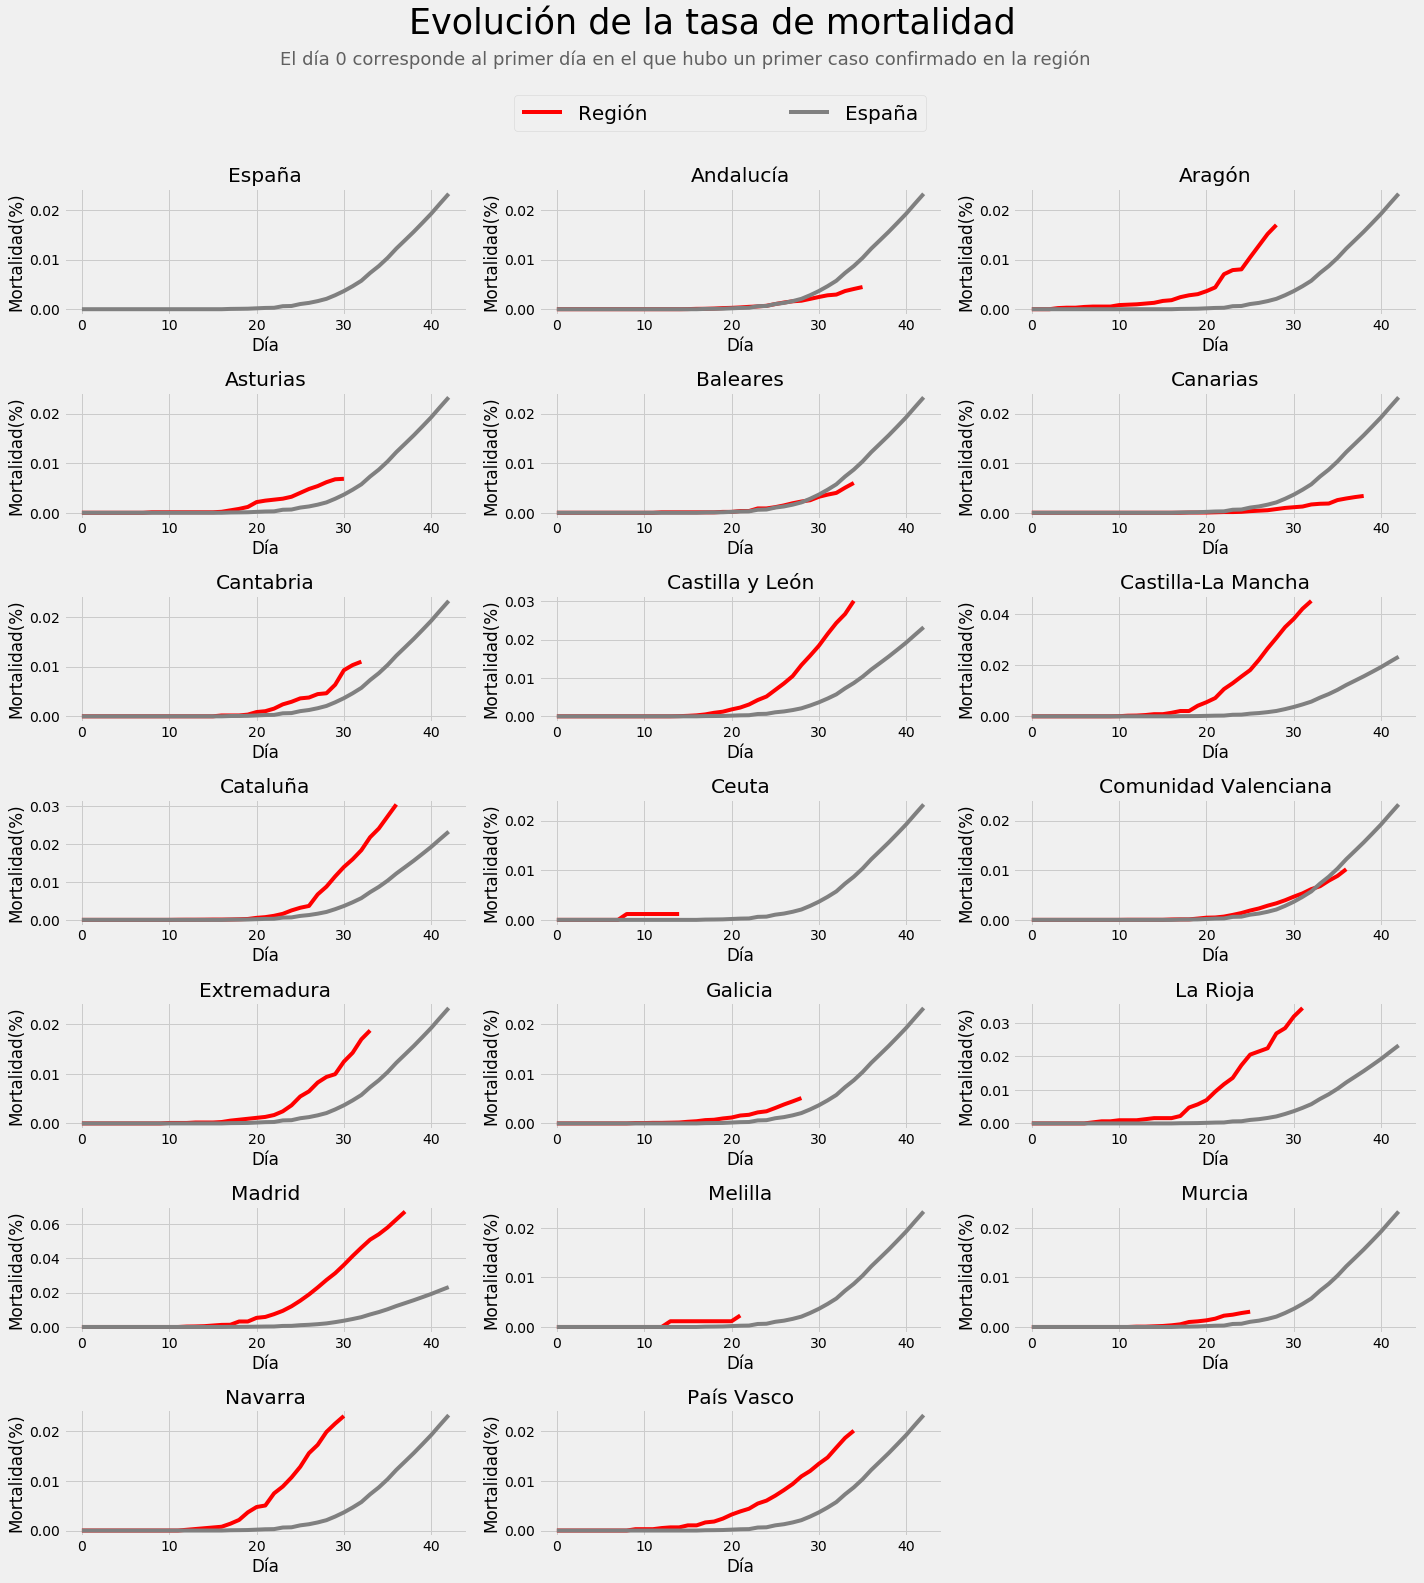

In [163]:
generateRegionsPlot('Mortalidad', 'Evolución de la tasa de mortalidad', 'Mortalidad(%)', 'red')

## Evolución de la tasa de letalidad

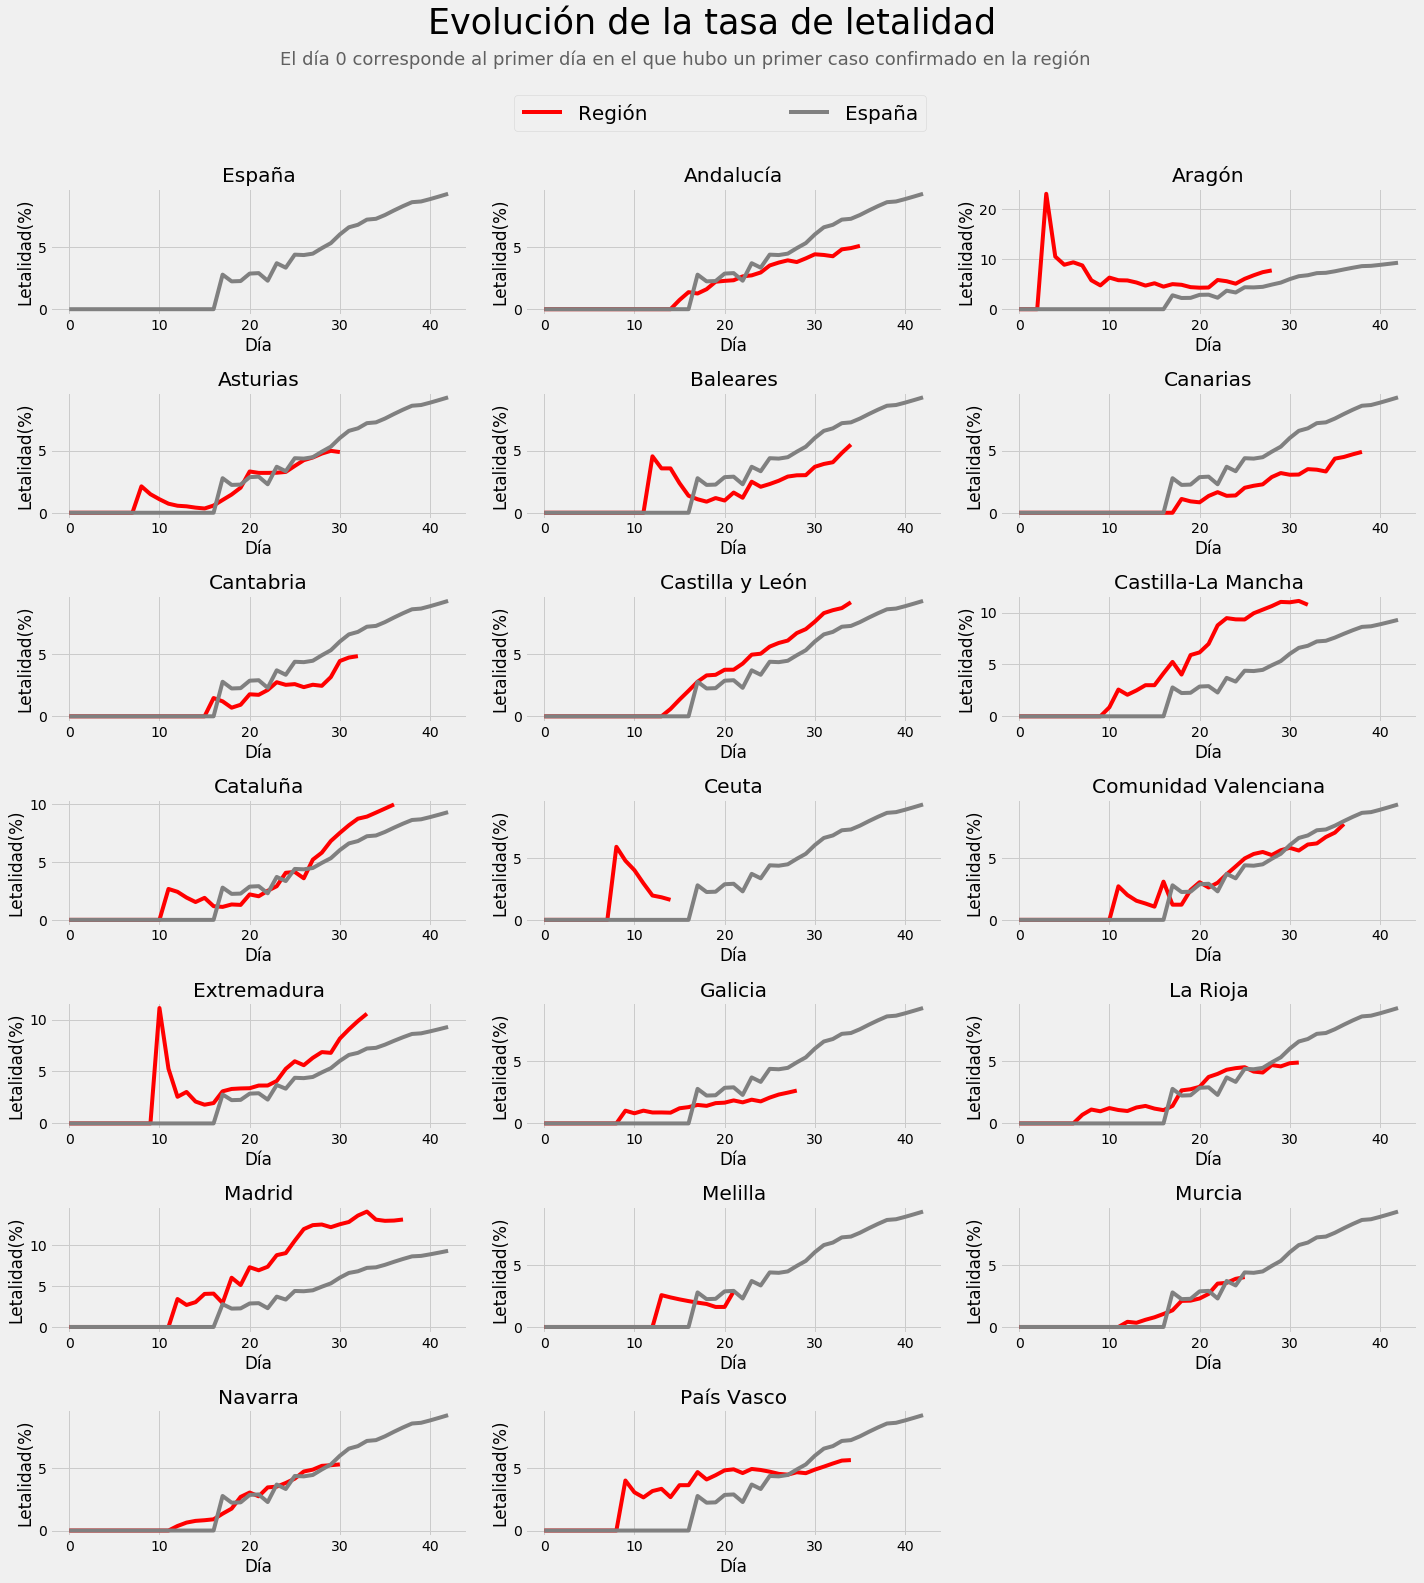

In [164]:
generateRegionsPlot('Letalidad', 'Evolución de la tasa de letalidad', 'Letalidad(%)', 'red')

## Evolución tasa de recuperación

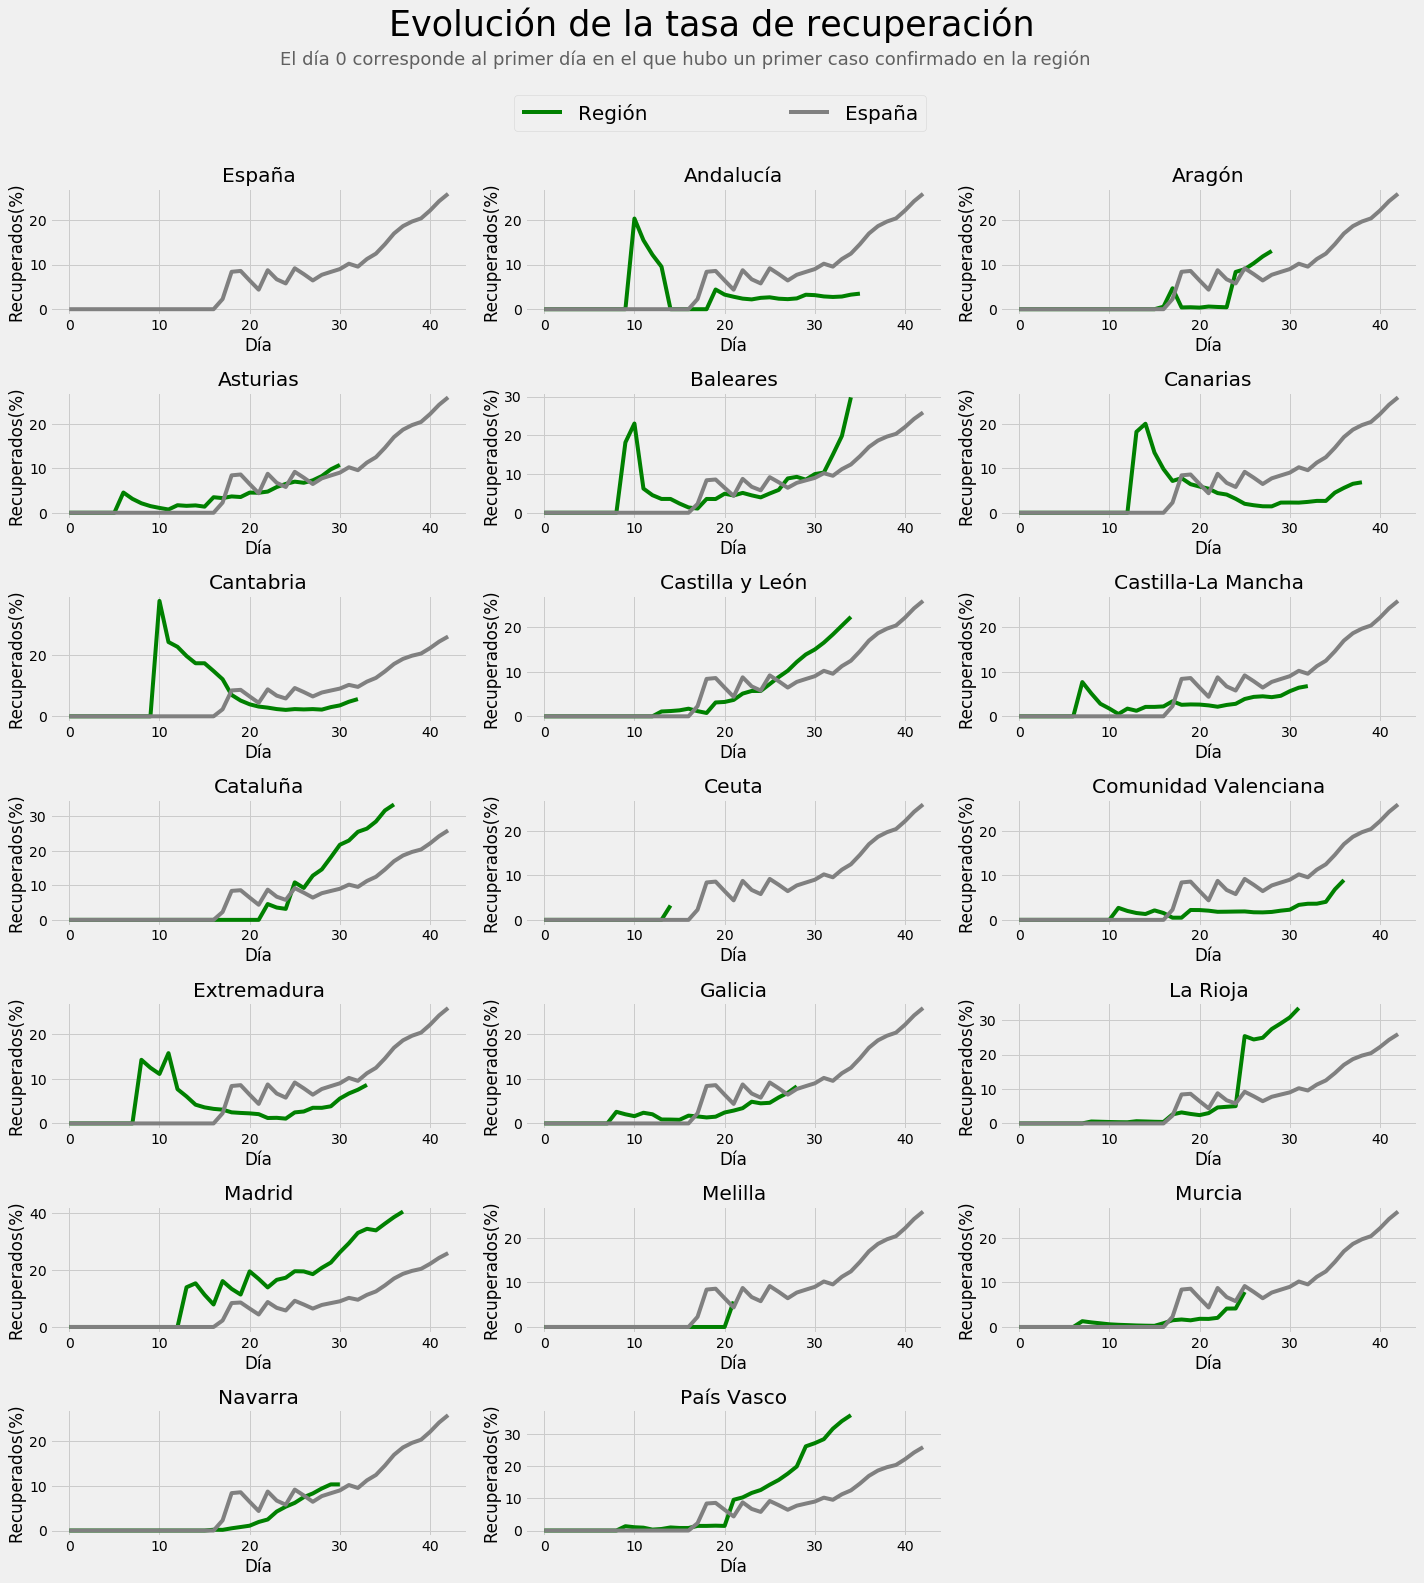

In [167]:
generateRegionsPlot('Tasa_recuperados', 'Evolución de la tasa de recuperación', 'Recuperados(%)', 'green')

## Mortalidad vs. Letalidad

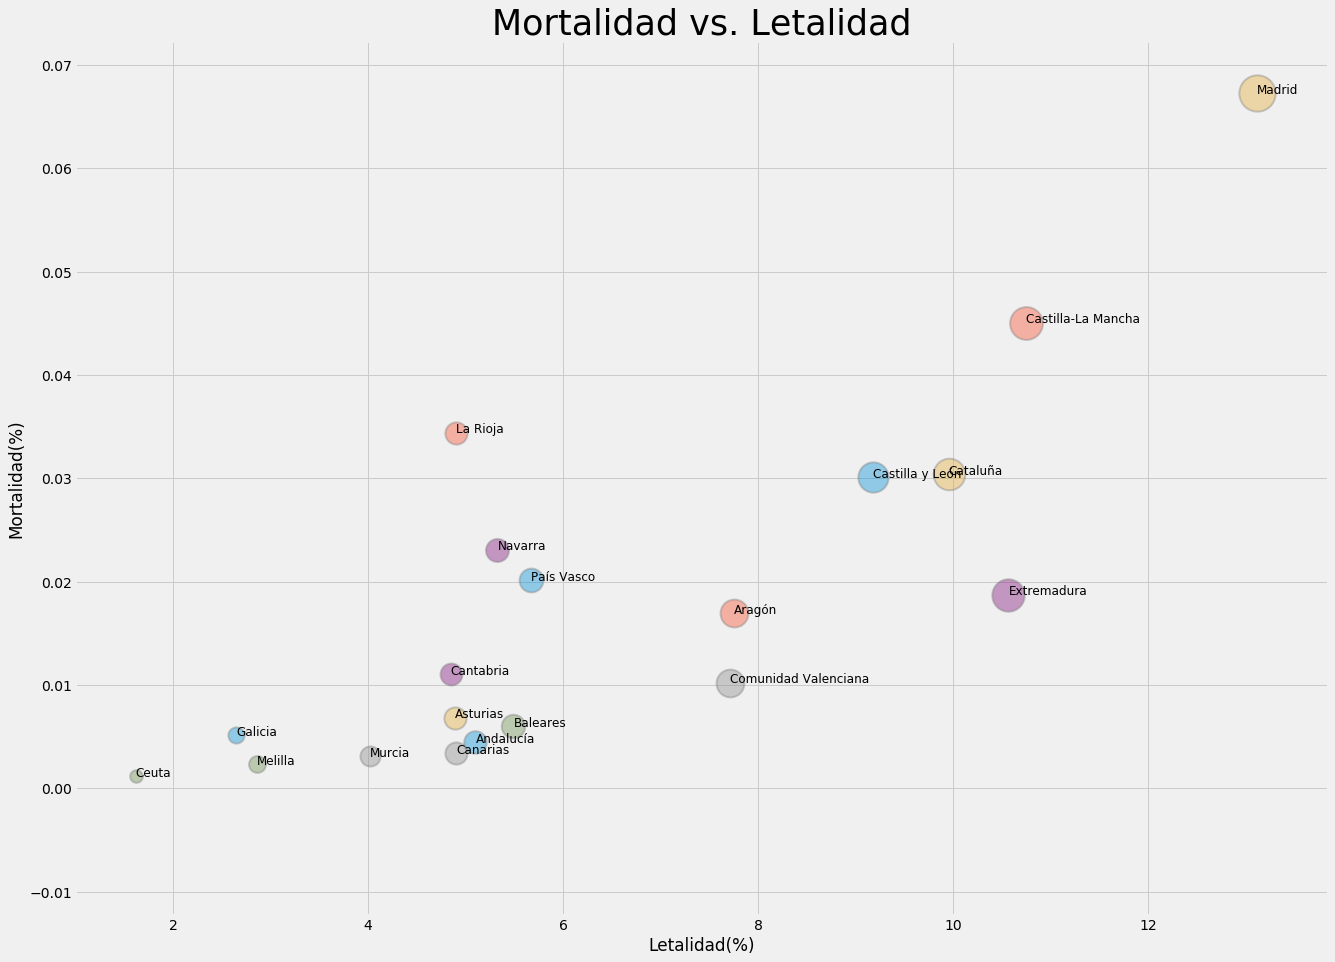

In [239]:
scatterPlot('Letalidad','Mortalidad', 'Letalidad(%)', 'Mortalidad(%)', 'Mortalidad vs. Letalidad')

## Mapa de mortalidad

## Mapa de letalidad